In [1]:
import pandas as pd            
data = pd.read_csv('../../usa-labelled.csv')
data.dtypes

Text                                  object
new_text                              object
languages                             object
new_text_after_translation            object
pos_tagged_words                      object
words_processed_all                   object
words_processed_noun_adj_verb_adv     object
words_processed_noun                  object
scores                                object
compound                             float64
sentiment                             object
dtype: object

In [4]:
# Label Encoding...

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data.sentiment)
data['categorical_label'] = le.transform(data.sentiment)
data.head()

,Text,new_text,languages,new_text_after_translation,pos_tagged_words,words_processed_all,words_processed_noun_adj_verb_adv,words_processed_noun,scores,compound,sentiment,categorical_label
0,cher i got my second pfizer vaccine shot may 1...,cher i got my second pfizer vaccine shot may 1...,ENGLISH,cher i got my second pfizer vaccine shot may 1...,"[('cher', 'NN'), ('i', 'NN'), ('got', 'VBD'), ...","['cher', 'get', 'second', 'pfizer', 'vaccine',...","['cher', 'get', 'second', 'pfizer', 'vaccine',...","['cher', 'pfizer', 'vaccine', 'cher', 'guess',...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,1
1,Ô£ø√º√≠√¢dp'ed by pfizer april Ô£ø√º√≤√•,syringedp'ed by pfizer april relieved_face,ENGLISH,syringedp'ed by pfizer april relieved_face,"[('syringe', 'NN'), ('ed', 'NN'), ('by', 'IN')...","['syringe', 'ed', 'pfizer', 'april']",['syringe'],['syringe'],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,1
2,Ô£ø√º√´√ßÔ£ø√º√®¬∫ double shot pfizer,thumbs_upmedium-light_skin_tone double shot pf...,ENGLISH,thumbs_upmedium-light_skin_tone double shot pf...,"[('double', 'RB'), ('shot', 'JJ'), ('pfizer', ...","['double', 'shot', 'pfizer']","['double', 'shot', 'pfizer']","['shot', 'pfizer']","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,1
3,couple things. my wife has ra. takes plaquenil...,couple things. my wife has ra. takes plaquenil...,ENGLISH,couple things. my wife has ra. takes plaquenil...,"[('couple', 'NN'), ('things', 'NNS'), ('my', '...","['couple', 'thing', 'wife', 'ra', 'take', 'pla...","['couple', 'thing', 'wife', 'take', 'plaquenil...","['couple', 'thing', 'wife', 'plaquenil', 'prob...","{'neg': 0.056, 'neu': 0.887, 'pos': 0.057, 'co...",0.0150,neutral,1
4,"great, me too back april. pfizer 2 shots","great, me too back april. pfizer 2 shots",ENGLISH,"great, me too back april. pfizer 2 shots","[('great', 'JJ'), ('me', 'PRP'), ('too', 'RB')...","['great', 'back', 'april', 'pfizer', 'two', 's...","['great', 'pfizer', 'shot']","['pfizer', 'shot']","{'neg': 0.0, 'neu': 0.594, 'pos': 0.406, 'comp...",0.6249,positive,2


In [5]:
# Tweet text preprocessing...

import json
import collections
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re
from nltk.tokenize import TweetTokenizer
def text_preprocess(text, tknzr):
    FLAGS = re.MULTILINE | re.DOTALL
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`-]?"
    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)
    text = re_sub(r"https?://S+b|www.(w+.)+S*", "")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@w+", "")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "")
    text = re_sub(r"{}{}p+".format(eyes, nose), "")
    # text = re_sub(r"{}{}(+|)+{}{}".format(eyes, nose, nose, eyes), "")
    text = re_sub(r"{}{}[/|l*]".format(eyes, nose), "")
    text = re_sub(r"<3","")
    text = re_sub(r"[-+]?[.d]*[d]+[:,.d]*", "")
    text = re_sub(r"([!?.]){2,}", r"1 ")
    text = re_sub(r"b(S*?)(.)2{2,}b", r"12 ")
    text = re_sub(r"[A-Za-z]+[@#$%^&*()]+[A-Za-z]*","abuse")
    tokens = tknzr.tokenize(text.lower())
    return tokens #" ".join(tokens)

tknzr=TweetTokenizer(reduce_len=True, preserve_case=False, strip_handles=False)


In [6]:
X = []
Y = []

for idx in data.index:
    X.append(text_preprocess(data['new_text_after_translation'][idx], tknzr))
    Y.append(data['categorical_label'][idx])

# Train-Test splitting
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
labels = ['Negative','Neutral', 'Positive']  # For further use...

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

# Loading USE encoder
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
use_model = hub.load(module_url)
print ("module %s loaded" % module_url)

def get_use_vector(doc):
  tmp = use_model(doc)
  return np.mean(tmp, axis=0)

# Convert text data into vector
train_vectors = []
for doc in X_train:
    try:
      train_vectors.append(get_use_vector(doc))
    except Exception:
      print('error...')
test_vectors = []
for doc in X_test:
    try:
      test_vectors.append(get_use_vector(doc))
    except Exception:
      print('error...')

2022-03-16 00:03:54.761386: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [8]:
# We calculate the following metrics to evaluate the model.

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# This utility function will be used to evaluate the other models also.
def show_performance_data(Y_test, Y_pred, model_name):
  print(classification_report(Y_test, Y_pred, target_names=labels))
  tmp_result = classification_report(Y_test, Y_pred, target_names=labels, output_dict=True)
  cm1 = confusion_matrix(Y_test, Y_pred)
  df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
  plt.figure(figsize = (7,5))
  sn.heatmap(df_cm, annot=True,cmap='gist_earth_r', fmt='g')
  plt.savefig('confusion_mrtx_'+model_name+'.png',bbox_inches = 'tight')
  return tmp_result



              precision    recall  f1-score   support

    Negative       0.42      0.62      0.50       152
     Neutral       0.55      0.17      0.26       101
    Positive       0.48      0.47      0.47       197

    accuracy                           0.45       450
   macro avg       0.48      0.42      0.41       450
weighted avg       0.47      0.45      0.43       450



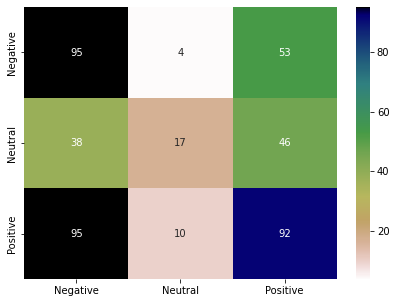

In [27]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(train_vectors, Y_train)
Y_pred = neigh.predict(test_vectors)
result_knn = show_performance_data(Y_test, Y_pred, 'knn')